In [3]:
# Install the 'dall-e' library if not already installed
!pip install dall_e
from dall_e import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

In [4]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

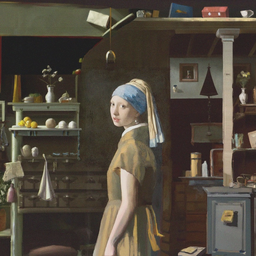

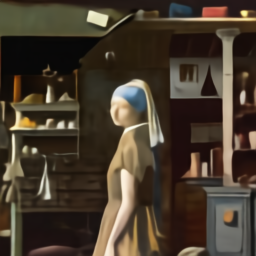

In [5]:
# Define the target size for images
target_image_size = 256

def download_image(url):
    """
    Downloads an image from the given URL and returns it as a PIL Image.
    """
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    """
    Preprocesses the input image to ensure it meets the required dimensions.
    """
    s = min(img.size)

    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')

    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

# Specify the device (CPU in this case)
dev = torch.device('cpu')

# Load the DALL-E models (encoder and decoder) from the given URLs
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

# Download and preprocess a sample image
x = preprocess(download_image('https://cdn.labellerr.com/Top%2010%20blogs/Top%2010%20Alternatives%20of%20Stable%20Diffusion/DALLE2.webp'))

# Display the original image
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

import torch.nn.functional as F

# Encode the image and obtain the latent representation
z_logits = enc(x)
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

# Reconstruct the image from the latent representation
x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

# Display the reconstructed image
display_markdown('Reconstructed image:')
display(x_rec)
